# a) Write your own Logistic Regression code, first step

In [1]:
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn import metrics
import scipy as sc
#plt.rcParams['figure.dpi'] = 150


# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

In [207]:
defaultfile = r"creditcard_data/defaults.xls"
nanDict = {}
df = pd.read_excel(defaultfile, header=1, skiprows=0, index_col=0, na_values=nanDict)
df.rename(index=str, columns={"default payment next month": "y"}, inplace=True)
print(df.shape)
df.head()

(30000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,y
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [219]:
count_no_def = len(df[df['y']==0])
count_def = len(df[df['y']==1])
pct_of_no_def = count_no_def/(count_no_def+count_def)
print(f"total number of no default: {count_no_def}")
print("percentage of no default is", pct_of_no_def*100)
pct_of_def = count_def/(count_no_def+count_def)
print(f"total number of defaults: {count_def}")
print("percentage of default", pct_of_def*100)

total number of no default: 23364
percentage of no default is 77.88000000000001
total number of defaults: 6636
percentage of default 22.12


In [2]:
def get_creditcard_data():
    """ Imports the data and sets up the scaled, dimensionality reduced
    feature matrix"""
    from sklearn.decomposition import PCA
    scaler = StandardScaler()
    onehotencoder = OneHotEncoder(categories="auto")
    
    defaultfile = r"creditcard_data/defaults.xls"
    nanDict = {}
    df = pd.read_excel(defaultfile, header=1, skiprows=0, index_col=0, na_values=nanDict)
    df.rename(index=str, columns={"default payment next month": "y"}, inplace=True)
    
    X = df.loc[:, df.columns != 'y'].values
    y = df.loc[:, df.columns == 'y'].values.ravel()

    pca = PCA(n_components=2)

    X = ColumnTransformer(
        [("", onehotencoder, [1, 2, 3]),],
        remainder="passthrough"
    ).fit_transform(X)
    
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=0)

    scaler.fit(Xtrain)
    
    Xtrain = scaler.transform(Xtrain)
    Xtest = scaler.transform(Xtest)
    
    pca.fit(Xtrain)
    
    Xtrain = pca.transform(Xtrain)
    Xtest = pca.transform(Xtest)
    
    return Xtrain, Xtest, ytrain, ytest, df

In [12]:
def dimred(df):
    """ Dimensionality reduction using PCA """
    from sklearn.decomposition import PCA
    logreg = LogisticRegression(solver="lbfgs")
    scaler = StandardScaler()
    onehotencoder = OneHotEncoder(categories="auto")

    
    X = df.loc[:, df.columns != 'y'].values
    y = df.loc[:, df.columns == 'y'].values.ravel()

    X = ColumnTransformer(
        [("", onehotencoder, [1, 2, 3]),],
        remainder="passthrough"
    ).fit_transform(X)
    
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)

    scaler.fit(Xtrain)
    
    Xtrain = scaler.transform(Xtrain)
    Xtest = scaler.transform(Xtest)
      
    
    covar_matrix = PCA(n_components = X.shape[1]) 
    covar_matrix.fit(X)
    variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios

    var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
    print(var) #cumulative sum of variance explained with [n] features
    
    
    logreg.fit(Xtrain, ytrain)
    print("All components test set accuracy: {:.2f}".format(logreg.score(Xtest,ytest)))
    
    ncomps = np.arange(1, X.shape[1]//2)
    
    for n in ncomps:
        pca = PCA(n_components = n)
        pca.fit(Xtrain)

        X2train = pca.transform(Xtrain)
        X2test = pca.transform(Xtest)
        
        logreg.fit(X2train, ytrain)
        print("# of components: {} | Test set accuracy: {:.2f}".format(n, logreg.score(X2test,ytest)))
    
#dimred(df)

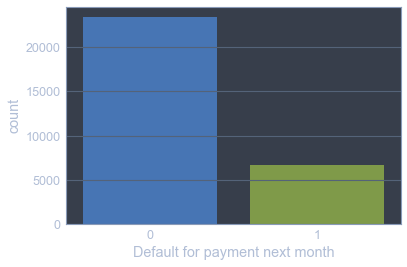

<Figure size 432x288 with 0 Axes>

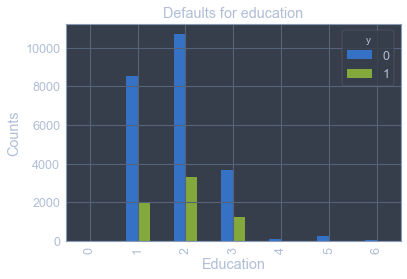

<Figure size 432x288 with 0 Axes>

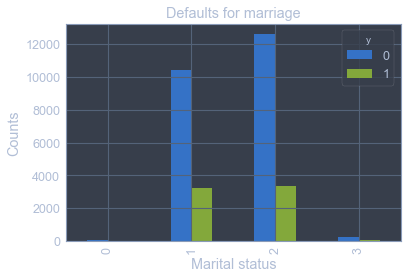

<Figure size 432x288 with 0 Axes>

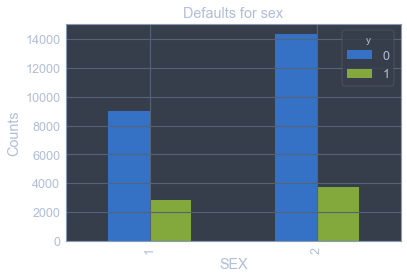

In [9]:
def plot_datafile():

    defaultfile = r"creditcard_data/defaults.xls"
    nanDict = {}
    df = pd.read_excel(defaultfile, header=1, skiprows=0, index_col=0, na_values=nanDict)
    df.rename(index=str, columns={"default payment next month": "y"}, inplace=True)
    
    plt.figure()
    sn.countplot("y", data=df)
    plt.xlabel("Default for payment next month")
    #plt.savefig("figures/defaultcounts.png", dpi=500)
    
    plt.figure()
    pd.crosstab(df.EDUCATION,df.y).plot(kind='bar')
    plt.title('Defaults for education')
    plt.xlabel('Education')
    plt.ylabel('Counts')
    plt.savefig("figures/educationcounts.png", dpi=500)
    
    plt.figure()
    pd.crosstab(df.MARRIAGE,df.y).plot(kind='bar')
    plt.title('Defaults for marriage')
    plt.xlabel('Marital status')
    plt.ylabel('Counts')
    plt.savefig("figures/marriagecounts.png", dpi=500)
    
    plt.figure()
    pd.crosstab(df.SEX,df.y).plot(kind='bar')
    plt.title('Defaults for sex')
    plt.ylabel('Counts')
    plt.savefig("figures/sexcounts.png", dpi=500)
    
plot_datafile()

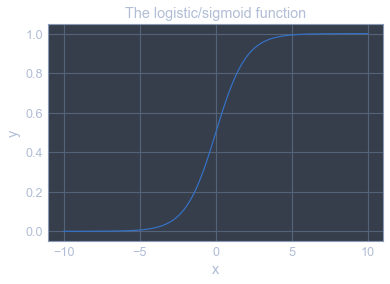

In [10]:
sigmoid = lambda t: np.exp(t)/(1 + np.exp(t))
t = np.linspace(-10, 10, 100)
plt.plot(t, sigmoid(t))
plt.xlabel("x"); plt.ylabel("y"); plt.title("The logistic/sigmoid function")
plt.savefig("figures/sigmoid.png", dpi=500)

In [107]:
np.random.seed(2212)
class LogReg(object):
    """ Logistic regressor model """
    def __init__(self, nfeatures):
        """ nfeatures should be number of predictors in the data set."""
        self.nfeatures = nfeatures
    
        self.beta = np.random.randn(nfeatures, 1) # initialize the coefficients randomly
        
        
    def train(self, traindata, testdata, epochs, eta, minibatch_size):
        """
        Perform a stochastic gradient descent in order to optimize the coefficients

        traindata: training data, should be a tuple with arrays, with (Xtrain, ytrain)
        testdata: testing data for validation, should be a tuple with (Xtest, ytest)
        epochs: no. of gradient descent iterations
        eta: learning rate
        minibatch_size: size of each minibatch
        """
        Xtrain, ytrain = traindata
        Xtest, ytest = testdata
    
        trainError = np.empty(epochs)
        testError = np.empty(epochs)
        
        n = Xtrain.shape[0]

        Xbatches = [Xtrain[k:k+minibatch_size] for k in range(0, n, minibatch_size)]
        ybatches = [ytrain[k:k+minibatch_size] for k in range(0, n, minibatch_size)]
        
        i = 0
        for j in range(epochs):
            epochLoss = 0.
            shuffle(Xbatches, ybatches, random_state=0)
            
            testError[j] = self.costfunc(Xtest, ytest)/Xtest.shape[0]
            
            gradient = 0.
            for (Xbatch, ybatch) in zip(Xbatches, ybatches):

                preds = self.predict(Xbatch) # fitted/predicted values for y=1 

                error = preds - ybatch
                
                epochLoss += np.sum(error**2)
                #print(gradient)
                
                gradient = (Xbatch.T @ error)/Xbatch.shape[0]
                self.beta += -eta*gradient # update the parameters

            trainError[j] = epochLoss/minibatch_size
            #print(f"Epoch {j+1} finished")

        return trainError, testError
        

    def costfunc(self, X, y):
        """
        Cost function/cross entropy
        -------------------------
        returns:
        cost of data set (X, y)
        """

        dotprod = X @ self.beta

        return -np.sum(y*dotprod - np.log(1 + np.exp(dotprod)))

    def predict(self, X):
        """
        Predict likelihood for y=1 given X[i]
        """
        return sigmoid(X @ self.beta)
        
sigmoid = lambda t: np.exp(t)/(1 + np.exp(t))

# Sigmoid gives likelihood for given event

In [110]:
import time
def creditcard_test(epochs):
    
    Xtrain, Xtest, ytrain, ytest = get_creditcard_data()[:-1]
    
    Xtrain = Xtrain[0::10]
    Xtest = Xtest[0::10]
    ytrain = ytrain[0::10]
    ytest = ytest[0::10]
    
    ytrain = ytrain.reshape(-1, 1)
    ytest = ytest.reshape(-1, 1)
    

    etas = np.logspace(-4, -1, 20)
    minibatch_size = Xtrain.shape[0]//10    
    trainErrors = np.empty((epochs, len(etas)))
    testErrors = np.empty((epochs, len(etas)))
    
    
    for (i, eta) in enumerate(etas):
        logreg = LogReg(Xtrain.shape[1])
        trainErrors[:,i], testErrors[:,i] = logreg.train((Xtrain, ytrain), (Xtest, ytest), epochs, eta, minibatch_size)
            
    #np.save(f"data/logreg_minibatch_times_{epochs}epochs", times)
    np.save("data/logreg_trainError_best_eta_new", trainErrors)
    np.save("data/logreg_testError_best_eta_new", testErrors)
creditcard_test(1000)

-4.0 0.66 1000 0
-3.84 1.0 1000 1
-3.68 0.76 1000 2
-3.53 1.22 1000 3
-3.37 0.65 1000 4
-3.21 0.65 1000 5
-3.05 0.65 1000 6
-2.89 0.65 215 7
-2.74 0.65 351 8
-2.58 0.65 1000 9
-2.42 0.65 1000 10
-2.26 0.65 67 11
-2.11 0.65 605 12
-1.95 0.65 391 13
-1.79 0.65 272 14
-1.63 0.65 190 15
-1.47 0.65 135 16
-1.32 0.65 9 17
-1.16 0.65 67 18
-1.0 0.65 45 19
0.04832930238571752


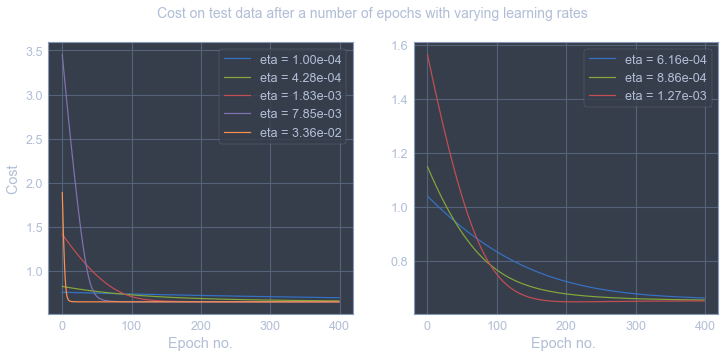

In [128]:
trainError = np.load("data/logreg_trainError_best_eta_new.npy")
testError = np.load("data/logreg_testError_best_eta_new.npy")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
etas = np.logspace(-4, -1, 20)

for i in range(0, len(etas), 4):
    
    ax1.plot(np.arange(0,400), testError[0:400,i], label=f"eta = {etas[i]:.2e}")


for i in range(1, 4):    
    ax2.plot(np.arange(0, 400), testError[0:400,i+4], label=f"eta = {etas[i+4]:.2e}")
ax1.legend()
ax2.legend()
plt.suptitle("Cost on test data after a number of epochs with varying learning rates", fontsize=14)
ax1.set_ylabel(" Cost ")
ax1.set_xlabel("Epoch no.")
ax2.set_xlabel("Epoch no. ")
fig.savefig("figures/logreg_learningrates.png", dpi=500)


for i in range(len(etas)):
    print(np.round(np.log10(etas[i]), 2), np.round(np.min(testError[:,i]), 2), np.argmin(testError[:,i])+1, i)
# best eta: 10^-4.42, epochs=137
print(etas[17])

Text(0, 0.5, 'log10 error/cost')

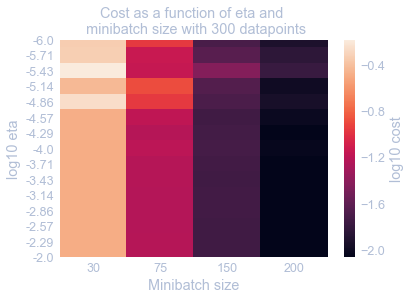

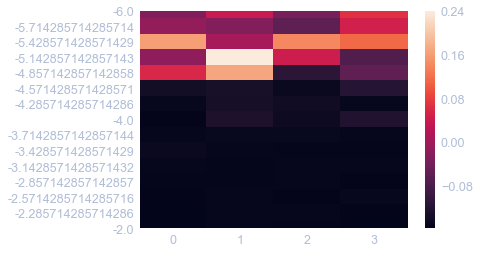

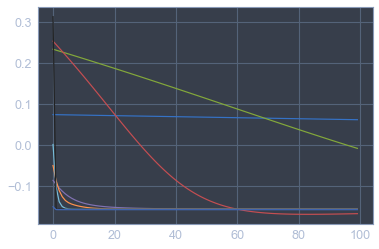

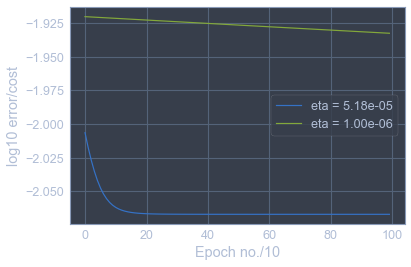

In [341]:
trainError = np.load("data/logreg_trainError.npy")
testError = np.load("data/logreg_testError.npy")
times = np.load("data/logreg_minibatch_times_1000epochs.npy")

etas = np.logspace(-6, -2, 15)
minibatch_sizes = np.array([int(300//i) for i in [10, 4, 2, 1.5]])

ax = sn.heatmap(np.mean(np.log10(trainError), axis=0), yticklabels=np.round(np.log10(etas), 2), xticklabels=minibatch_sizes)
ax.collections[0].colorbar.set_label("log10 cost")
ax.set_xlabel("Minibatch size")
ax.set_ylabel("log10 eta")
ax.set_title("Cost as a function of eta and \n minibatch size with 300 datapoints")
#plt.savefig("figures/cost_etas_mbsize.png", dpi=500)
                                     
plt.figure()
sn.heatmap(np.mean(np.log10(testError), axis=0), yticklabels=np.log10(etas))

plt.figure()
for e in range(0, len(etas), 2):
    plt.plot(np.arange(0, 100), np.log10(testError[:,e,-1]))

plt.figure()
plt.plot(np.arange(0, 100), np.log10(trainError[0::10,-9,-1]), 
         label=f"eta = {etas[-9]:.2e}")
plt.plot(np.arange(0, 100), np.log10(trainError[0::10, 0, -1]),
        label = f"eta = {etas[0]:.2e}")
plt.legend()
plt.xlabel("Epoch no./10")
plt.ylabel("log10 error/cost")
#plt.savefig("figures/logreg_eta_diffs.png", dpi=500)



In [103]:
def predict_creditcard_logreg():
    Xtrain, Xtest, ytrain, ytest = get_creditcard_data()[:-1]
    from sklearn.metrics import f1_score, accuracy_score
    import time
    
    eta = 10**(-1.79)
    
    epochs= 300
    minibatch_size = Xtrain.shape[0]//10
    
    ytrain = ytrain.reshape(-1, 1)
    ytest = ytest.reshape(-1, 1)
    
    totaltime = 0.
    start = time.perf_counter()
    for i in range(10):
        logreg = LogReg(Xtrain.shape[1])
        logreg.train((Xtrain, ytrain), (Xtest, ytest), epochs, eta, minibatch_size)
        totaltime += time.perf_counter() - start        
    totaltime /= 10
    
    ypred = logreg.predict(Xtest).ravel()
    ypred = [np.argmax([1-i, i]) for i in ypred]
    
    print(" Own model: ")
    print(f1_score(ytest.ravel(), ypred))
    print(accuracy_score(ytest.ravel(), ypred))
    print(f"Time: {totaltime}s")

    start = time.perf_counter()
    logreg_sk = LogisticRegression(solver="lbfgs")
    logreg_sk.fit(Xtrain, ytrain.ravel())
    ypred_sk = logreg_sk.predict(Xtest)
    totaltime = time.perf_counter() - start

    print(" With Scikit ")
    print(f1_score(ytest.ravel(), ypred_sk))
    print(accuracy_score(ytest.ravel(), ypred_sk))
    print(f"Time: {totaltime}s")

    
predict_creditcard_logreg()

 Own model: 
0.4086021505376344
0.5691666666666667
Time: 2.989438669998708s
 With Scikit 
0.23824855119124275
0.8028333333333333
Time: 0.016618599998764694s


# Neural Network

In [3]:
np.random.seed(2212)

#sigmoid = lambda t: np.exp(t)/(1 + np.exp(t))
sigmoid = lambda t: 0.5*(np.tanh(t/2) + 1)
sigmoid_prime = lambda t : sigmoid(t)*(1-sigmoid(t))

from sklearn.metrics import f1_score, accuracy_score


class NeuralNet_cc(object):
    """Neural network for classification using cross-entropy cost function
    and sigmoid activation function"""
    def __init__(self, layers, costf):
        """
        - layers: list of no. of neurons in each layer (including input and output)
        - costf: tuple with costfunction and costfunction derivative with respect to activation
        """

        self.costfunc = costf[0]
        self.costfunc_prime = costf[1]

        self.layers = layers

        self.num_layers = len(layers)
        self.weights = [np.random.randn(y, x) for x, y in zip(self.layers[:-1], self.layers[1:])]
        self.bias = [np.random.randn(x, 1) for x in self.layers[1:]]

    def feedforward(self, x):
        """
        Output of network with input x
        """

        """a_old = sigmoid(x) # activation in the first layer

        for i in range(self.num_layers - 1):
            a_new = sigmoid((self.weights[i] @ a_old) + self.bias[i])
            a_old = a_new

        return a_old"""

        #a = sigmoid(x)
        a = x
        for w, b in zip(self.weights, self.bias):
            a = sigmoid(np.dot(w, a)+b)
        return a


    def SGD(self, data, epochs, eta, minibatch_size, _lambda):
        """ Stochastic gradient descent with minibatches """

        trainErrors = np.empty(epochs)
        testErrors = np.empty(epochs)

        trainScores = np.empty(epochs)
        testScores = np.empty(epochs)

        Xtrain, ytrain = data[0]
        Xtest, ytest = data[1]
    
        n = Xtrain.shape[0]

        Xbatches = [Xtrain[k:k+minibatch_size] for k in range(0, n, minibatch_size)]
        ybatches = [ytrain[k:k+minibatch_size] for k in range(0, n, minibatch_size)]

        ytest_nohot = np.array([np.argmax(y) for y in ytest]).reshape(-1, 1)
        for j in range(epochs):
            shuffle(Xbatches, ybatches, random_state=0)

            batchTrainError = 0.
            batchTrainScore = 0.

            ytestpreds = self.predict(Xtest)
            testErrors[j] = self.cost(Xtest, ytest, _lambda)
            testScores[j] = f1_score(ytest_nohot.ravel(), ytestpreds)

            for (Xbatch, ybatch) in zip(Xbatches, ybatches):

                ybatch_nohot = np.array([np.argmax(y) for y in ybatch]).reshape(-1, 1)
                ytrainpreds = self.predict(Xbatch)
                batchTrainError += self.cost(Xbatch, ybatch, _lambda)
                batchTrainScore += f1_score(ybatch_nohot.ravel(), ytrainpreds)

                nabla_b = [np.zeros((x, 1)) for x in self.layers[1:]]
                nabla_w = [np.zeros((y, x)) for x, y in zip(self.layers[:-1], self.layers[1:])]

                for (x, y) in zip(Xbatch, ybatch):
                    x = x.reshape(-1, 1)
                    y = y.reshape(-1, 1)

                    d_nabla_b, d_nabla_w = self.backpropagate(x, y)

                    nabla_b = [nablab + deltab for nablab, deltab in zip(nabla_b, d_nabla_b)]
                    nabla_w = [nablaw + deltaw for nablaw, deltaw in zip(nabla_w, d_nabla_w)]

                # update weights and biases
                self.weights = [w - (eta/len(Xbatch))*nablaw - eta*_lambda/n*w for (w, nablaw) in zip(self.weights, nabla_w)]
                self.bias = [b - (eta/len(Xbatch))*nablab for (b, nablab) in zip(self.bias, nabla_b)]

            trainErrors[j] = batchTrainError/len(Xbatches)
            trainScores[j] = batchTrainScore/len(Xbatches)

        return trainErrors, trainScores, testErrors, testScores

    def backpropagate(self, x, y):
        """
        Backpropagate the error with activation from input layer a
        Calculates delta in layer L, then delta for layer L-1, L-2, ... , 2
        """
        weighted_input = [np.empty((l, 1)) for l in self.layers[1:]] # z
        activations = [np.empty((l, 1)) for l in self.layers]        # a

        #  activations and weighted inputs for all layers
        activations[0] = x
        weighted_input = [(self.weights[l] @ activations[l]) + self.bias[l] for l in range(self.num_layers - 1)]
        activations[1:] = [sigmoid(z) for z in weighted_input]

        deltaL = self.costfunc_prime(activations[-1], y, weighted_input[-1]) # error of the output neurons

        deltas = [np.zeros((x, 1)) for x in self.layers[1:]] # errors from neurons in each layer, starting from layer 2
        deltas[-1] = deltaL # error from output layer

        # backpropagate the error
        for l in range(self.num_layers - 3, -1, -1):

            sp = sigmoid_prime(weighted_input[l])
            dp = self.weights[l+1].T @ deltas[l+1]

            deltas[l] = np.multiply((dp), sp)


        # gradients
        d_nabla_b = deltas
        d_nabla_w = [(d_nabla_b[l] @ activations[l].T) for l in range(self.num_layers - 1)]

        return d_nabla_b, d_nabla_w


    def cost(self, X, y, _lambda):
        """ Total cost of the data batch (X, y) """
        cost = 0.
        n = len(X)


        for (x, yy) in zip(X, y):
            o = self.feedforward(x.reshape(-1, 1))

            cost += self.costfunc(o, yy)/n

        if _lambda != 0:
            wsum = sum(np.linalg.norm(w)**2 for w in self.weights)
            cost +=  0.5*_lambda/n*wsum
        return cost

    def predict(self, X):

        preds = np.empty(len(X))

        for i in range(len(preds)):
            preds[i] = np.argmax(self.feedforward(X[i].reshape(-1, 1)))

        return preds
    
def cross_entropy(o, y):
      return np.sum(np.nan_to_num(-y*np.log(o) - (1 - y)*np.log(1 - o)))
    
def cross_entropy_prime(o, y, z):
    return o - y

def quadratic_cost(o, y):
    return 0.5*np.linalg.norm(o - y)**2

def quadratic_cost_prime(o, y, z):
    return (o - y) * sigmoid_prime(z)

crossentropy = (cross_entropy, cross_entropy_prime)
quadraticcost = (quadratic_cost, quadratic_cost_prime)

In [145]:
def creditcard_neuralnet():
    import time 
    enc = OneHotEncoder(categories="auto")

    Xtrain, Xtest, ytrain, ytest = get_creditcard_data()[:-1]
    
    Xtrain = Xtrain[0::300]
    Xtest = Xtest[0::300]
    ytrain = ytrain[0::300]
    ytest = ytest[0::300]
    
    ytrain = ytrain.reshape(-1, 1)
    ytest = ytest.reshape(-1, 1)
    
    ytest_nohot = ytest
    enc.fit(ytrain)
    ytrain = enc.transform(ytrain).toarray()
    ytest = enc.transform(ytest).toarray()
    
    minibatch_size = Xtrain.shape[0]//10
    etas = np.logspace(-6, -2, 10)
    epochs = 300
    
    firstlayer = Xtrain.shape[1]
    finallayer = ytrain.shape[1]
    layerss = [[firstlayer, finallayer],
              [firstlayer, 10, finallayer],
              [firstlayer, 100, finallayer],
              [firstlayer, 10, 10, finallayer],
              [firstlayer, 100, 10, finallayer]]
    
    
    
    trainErrors = np.empty((len(layerss), len(etas), epochs))
    testErrors = np.copy(trainErrors)
    
    trainScores = np.copy(trainErrors)
    testScores = np.copy(trainErrors)
    
    times = np.empty(len(layerss))
    
    data = ([Xtrain, ytrain], [Xtest, ytest])
    for (i, layers) in enumerate(layerss):
        totaltime = 0.
        for (j, eta) in enumerate(etas):
                start = time.perf_counter()
                neuralnet = NeuralNet_cc(layers, crossentropy)
                trainErrors[i, j], trainScores[i, j], testErrors[i, j], testScores[i, j] = neuralnet.SGD(data, epochs, eta, minibatch_size, 0)
                totaltime += time.perf_counter() - start
        times[i] = totaltime/len(etas)
    
    np.save("neuralnet_etas_train", (trainErrors, trainScores))
    np.save("neuralnet_etas_test", (testErrors, testScores))
    np.save("neuralnet_times_new", times)
creditcard_neuralnet()

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\caspa\Anaconda3\lib\site-packages\ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
C:\Users\caspa\Anaconda3\lib\site-packages\ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply
C:\Users\caspa\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: overflow encountered in double_scalars
C:\Users\caspa\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Eta = 1.00e-06
Layer = [2, 2] | min. cost = 4.9257 at epoch = 299 
 best score: 0.42857142857142855
Layer = [2, 10, 2] | min. cost = 3.1358 at epoch = 0 
 best score: 0.26666666666666666
Layer = [2, 100, 2] | min. cost = 8.2360 at epoch = 0 
 best score: 0.0
Layer = [2, 10, 10, 2] | min. cost = 3.0014 at epoch = 0 
 best score: 0.4
Layer = [2, 100, 10, 2] | min. cost = 5.8162 at epoch = 299 
 best score: 0.5
Eta = 2.78e-06
Layer = [2, 2] | min. cost = 7.1256 at epoch = 299 
 best score: 0.3529411764705882
Layer = [2, 10, 2] | min. cost = 3.5317 at epoch = 299 
 best score: 0.43478260869565216
Layer = [2, 100, 2] | min. cost = 9.9766 at epoch = 299 
 best score: 0.5
Layer = [2, 10, 10, 2] | min. cost = 3.8123 at epoch = 299 
 best score: 0.5185185185185185
Layer = [2, 100, 10, 2] | min. cost = 4.7654 at epoch = 299 
 best score: 0.0
Eta = 7.74e-06
Layer = [2, 2] | min. cost = 4.7778 at epoch = 299 
 best score: 0.2
Layer = [2, 10, 2] | min. cost = 3.7560 at epoch = 299 
 best score: 0.5

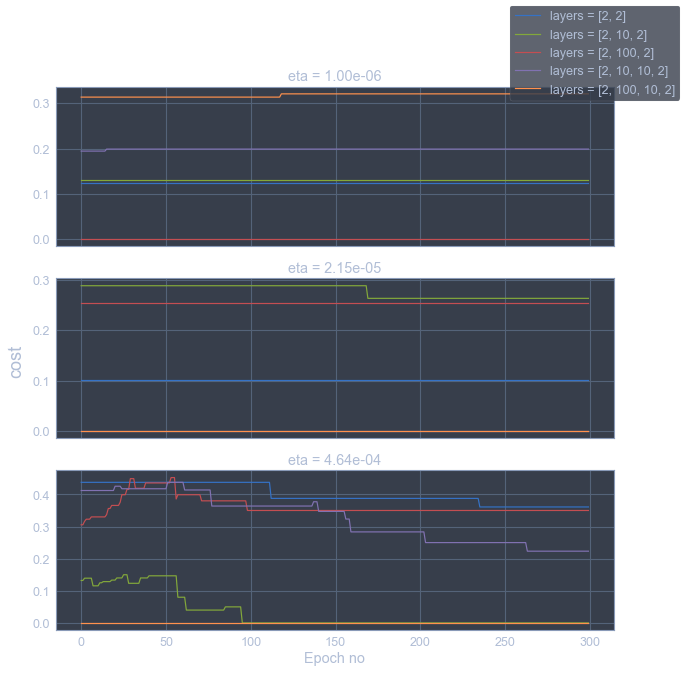

In [147]:
testErrors, testScores = np.load("neuralnet_etas_test.npy")
trainErrors, trainScores = np.load("neuralnet_etas_train.npy")
times = np.load("neuralnet_times_new.npy")

etas = np.logspace(-6, -2, 10)
layers = [[2, 2], [2, 10, 2], [2, 100, 2], [2, 10, 10, 2], [2, 100, 10, 2]]


#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
epochss = np.arange(0, 300)
for i in range(len(layers)):
    #ax1.plot(np.arange(0, 300), testing[i,5])
    #ax2.plot(np.arange(0, 300), training[i,5])
    ax1.plot(epochss, trainScores[i,0])
    ax2.plot(epochss, trainScores[i,3])
    ax3.plot(epochss, trainScores[i,6], label=f"layers = {layers[i]}")

fig.legend()
ax1.set_title(f"eta = {etas[0]:.2e}")
ax2.set_title(f"eta = {etas[3]:.2e}")
ax3.set_title(f"eta = {etas[6]:.2e}")


ax3.set_xlabel("Epoch no")
fig.text(0.07, 0.5, 'cost', ha='center', va='center', rotation='vertical', fontsize=18)


for i in range(len(etas)):
    print(f"Eta = {etas[i]:.2e}")
    for j in range(len(layers)):
        print(f"Layer = {layers[j]} | min. cost = {np.min(trainErrors[j, i]):.4f} at epoch = {np.argmin(trainErrors[j,i])} \n best score: {np.max(testScores[j,i])}")

In [48]:
def study_overfitting():   
    
    Xtrain, Xtest, ytrain, ytest = get_creditcard_data()[:-1]
    eta = 1e-2
    epochs = 500
    minibatch_size = Xtrain.shape[0]//10
    layers = [2, 10, 2]
    

    # use only 100 datapoints to precipitate overfitting
    Xtrain = Xtrain[0::100]
    Xtest = Xtest[0::100]
    ytrain = ytrain[0::100]
    ytest = ytest[0::100]
    
    ytrain = ytrain.reshape(-1, 1)
    ytest = ytest.reshape(-1, 1)
    
    enc = OneHotEncoder(categories="auto")
    enc.fit(ytrain)
    ytrain = enc.transform(ytrain).toarray()
    ytest = enc.transform(ytest).toarray()
    
    data = ([Xtrain, ytrain], [Xtest, ytest])
    
    lambdas = np.logspace(-3, 2, 5)
    lambdas = [lam for lam in lambdas]
    lambdas.append(0.)
    
    
    trainErrors = np.empty((len(lambdas), epochs))
    trainScores = np.copy(trainErrors)
    
    testErrors = np.copy(trainErrors)
    testScores = np.copy(trainErrors)

    
    for (i, lam) in enumerate(lambdas):
        neuralnet = NeuralNet_cc(layers, crossentropy)
        trainErrors[i,:], trainScores[i,:], testErrors[i,:], testScores[i,:] = neuralnet.SGD(data, epochs, eta, minibatch_size, lam)
    
    np.save("overfitting_params", (layers, lambdas, epochs))
    np.save("overfitting_train", (trainErrors, trainScores))
    np.save("overfitting_test", (testErrors, testScores))
    
    
study_overfitting()

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


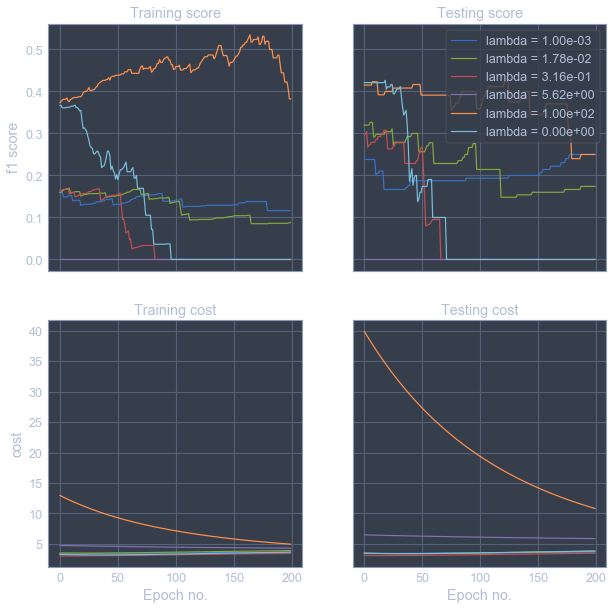

In [50]:
def plot_overfitting():
    layers, lambdas, epochs = np.load("overfitting_params.npy", allow_pickle=True)
    trainErrors, trainScores = np.load("overfitting_train.npy")
    testErrors, testScores = np.load("overfitting_test.npy")
    
    xepochs = np.arange(0, epochs)
    fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(10, 10), sharey="row", sharex="all")
    for i in range(len(lambdas)):
        ax1[0].plot(xepochs, trainScores[i])
        ax1[1].plot(xepochs, testScores[i], label=f"lambda = {lambdas[i]:.2e}")
        
        ax2[0].plot(xepochs, trainErrors[i])
        ax2[1].plot(xepochs, testErrors[i])
    ax1[1].legend()
    
    ax1[0].set_title("Training score")
    ax1[1].set_title("Testing score")
    ax1[0].set_ylabel("f1 score")
    
    ax2[0].set_title("Training cost")
    ax2[1].set_title("Testing cost")
    ax2[0].set_ylabel("cost")
    ax2[0].set_xlabel("Epoch no.")
    ax2[1].set_xlabel("Epoch no.")
    
    fig.savefig("figures/overfitting.png", dpi=500)
plot_overfitting()

In [140]:
def predict_neuralnet():
    """
    Train model with best chosen parameters and compare model with scikit-learn's MLP
    """
    from sklearn.metrics import f1_score, accuracy_score
    from sklearn.neural_network import MLPClassifier
    import time 
    

    enc = OneHotEncoder(categories="auto")
    time_self = 0.
    time_sk = 0.
    
    # network and training parameters
    eta = 1.00e-03
    epochs = 1
    layers = [2, 100, 2]
    
    """ prepare data """
    Xtrain, Xtest, ytrain, ytest = get_creditcard_data()[:-1]
    
    Xtrain = Xtrain[0::100]
    Xtest = Xtest[0::100]
    ytrain = ytrain[0::100]
    ytest = ytest[0::100]

    minibatch_size = Xtrain.shape[0]//10

    ytrain = ytrain.reshape(-1, 1)
    ytest = ytest.reshape(-1, 1)
    ytest_nohot = ytest
    
    enc.fit(ytrain)
    ytrain = enc.transform(ytrain).toarray()
    ytest = enc.transform(ytest).toarray()
    
    data = ([Xtrain, ytrain], [Xtest, ytest])
    
    """ initialize network and train """
    start = time.perf_counter()
    neuralnet = NeuralNet_cc(layers, crossentropy)
    neuralnet.SGD(data, epochs, eta, minibatch_size, 0)
    
    """ predict with own network """
    ypreds = neuralnet.predict(Xtest) 
    time_self = time.perf_counter() - start
    
    """ initialize and fit scikit MLP network """
    start = time.perf_counter()
    classifier = MLPClassifier(hidden_layer_sizes=(100), max_iter=epochs, activation = 'logistic', solver='sgd', 
                               batch_size = minibatch_size, alpha=0., random_state=1, learning_rate_init=eta)
    
    classifier.fit(Xtrain, ytrain)
    
    """ predict with scikit network """
    ypreds_scikit = classifier.predict(Xtest)
    time_sk = time.perf_counter() - start
    
    ypreds_scikit = np.array([np.argmax(i) for i in ypreds_scikit])

    """ score and compare """
    print(f"Own f1 score: {f1_score(ytest_nohot.ravel(), ypreds)} | time: {time_self}s" )
    print(f"Scikit f1 score: {f1_score(ytest_nohot.ravel(), ypreds_scikit)} | time: {time_sk}s")
    
predict_neuralnet()

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Own f1 score: 0.0 | time: 0.08297239999956219s
Scikit f1 score: 0.0 | time: 0.019860600004903972s


C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
def test_scikit():
    """ 
    Test various activation functions and solvers with sklearn's MLP module
    """
    from sklearn.neural_network import MLPClassifier
      
    enc = OneHotEncoder(categories="auto")
    Xtrain, Xtest, ytrain, ytest = get_creditcard_data()[:-1]
    minibatch_size = Xtrain.shape[0]//10

    ytrain = ytrain.reshape(-1, 1)
    ytest = ytest.reshape(-1, 1)
    ytest_nohot = ytest
    
    enc.fit(ytrain)
    ytrain = enc.transform(ytrain).toarray()
    ytest = enc.transform(ytest).toarray()
    
    
    activations = ["identity", "logistic", "tanh", "relu"]
    solvers = ["lbfgs", "sgd", "adam"]
    
    scores = np.empty((len(activations), len(solvers)))
    
    for (i, act) in enumerate(activations):
        for (j, solver) in enumerate(solvers):
            classifier = MLPClassifier(hidden_layer_sizes=(100), activation = act, solver=solver, 
                                       batch_size = minibatch_size, alpha=0., random_state=1, learning_rate_init=eta)
        
            classifier.fit(Xtrain, ytrain)
            ypreds_scikit = classifier.predict(Xtest)
            time_sk = time.perf_counter() - start

            ypreds_scikit = np.array([np.argmax(i) for i in ypreds_scikit])
            
            scores[i, j] = f1_score(ytest_nohot.ravel(), ypreds_scikit)
            

# Regression

In [6]:
from imageio import imread


def get_terrain_data(slicex=180, slicey=90, plot=False):
    """Extract an image of size 20x20. Thanks to the guy on piazza."""
    terrain = imread("terraindata/SRTM_data_Norway_2.tif")
    stdscaler = StandardScaler()
    minmaxscaler = MinMaxScaler()
    
    z = terrain[0::slicex, 0::slicey]
    x = np.linspace(0, 1, z.shape[1])
    y = np.linspace(0, 1, z.shape[0])
    xx, yy = np.meshgrid(x, y)
    
    zshape = z.shape
    z = z.ravel().reshape(-1, 1)
    X = create_design_matrix(xx, yy)
        
    Xtrain, Xtest, ztrain, ztest = train_test_split(X, z, test_size=0.2, random_state=22)
    
    stdscaler.fit(ztrain)
    
    ztrain = stdscaler.transform(ztrain)
    ztest = stdscaler.transform(ztest)
    
    minmaxscaler.fit(ztrain)
    
    ztrain = minmaxscaler.transform(ztrain)
    ztest = minmaxscaler.transform(ztest)
    
    z = stdscaler.fit_transform(z)
    z = minmaxscaler.fit_transform(z)
    
    return X, Xtrain, Xtest, ztrain, ztest, z, zshape

            
def create_design_matrix(xx, yy):
    """ Create design matrix from (x, y) meshgrid such that 
    X[i] = [xi, yi]    
    """
    xx = xx.ravel()
    yy = yy.ravel()
    
    X = np.empty((len(xx), 2))
    
    X[:,0] = xx
    X[:,1] = yy
    """for i in range(len(X)):
        X[i, 0] = xx[i]
        X[i, 1] = yy[i]"""
        
    return X

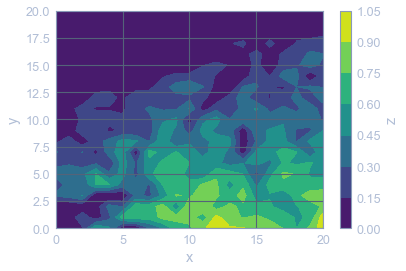

In [245]:
z = get_terrain_data()[-2]
plt.contourf(z.reshape(21, 21))
plt.xlabel("x"), plt.ylabel("y")
plt.colorbar(label="z")
plt.savefig("figures/terraindata.png", dpi=500)

In [5]:
def neuralnet_terrain():
    
    X, Xtrain, Xtest, ztrain, ztest, z, zshape = get_terrain_data()
    
    costfunc = quadraticcost
    
    minibatch_size = len(Xtrain)//10
    eta = 1.0e-3
    
    epochs = [200, 300, 400, 500]
    hidden_neurons = [2, 10, 50, 100]
    
    trainErrors = [np.empty((ep, 4)) for ep in epochs]
    testErrors = [np.empty((ep, 4)) for ep in epochs]
    
    data = ([Xtrain, ztrain], [Xtest, ztest])
    for (i, epoch) in enumerate(epochs):


        for (j, hidden_neuron) in enumerate(hidden_neurons):
    
            layers = [Xtrain.shape[1], hidden_neuron, 1]

            neuralnet = NeuralNet_cc(layers, costfunc)

            trainErrors[i][:,j], testErrors[i][:,j] = neuralnet.SGD(data, epoch, eta, minibatch_size, 0.1)[0:3:2]

            #testcost[i, j] = neuralnet.cost(Xtest, ztest, 0)

    for i in range(len(epochs)):
        plt.figure()
        for j in range(4):
            plt.plot(np.arange(0, epochs[i]) ,testErrors[i][:,j], label=f"n = {hidden_neurons[j]}")
        plt.legend()
    testcost = [testErrors[i][-1,:] for i in range(len(epochs))]
    sn.heatmap(testcost, xticklabels=epochs, yticklabels=hidden_neurons, annot=True, cbar_kws={'label': 'MSE'})
    plt.ylabel("Neurons in hidden layer")
    plt.xlabel("Epochs")
    plt.ylim(0, len(epochs))
    plt.savefig("terrain_heatmap_new.png", dpi=500)
    
    layers = [Xtrain.shape[1], 100, 1]
    neuralnet = NeuralNet_cc(layers, costfunc)
    neuralnet.SGD(data, 300, eta, minibatch_size, 0)
    
    zz = np.empty((len(X), 1))
    for i in range(len(X)):
        zz[i] = neuralnet.feedforward(X[i].reshape(-1,1))

    np.save("predicted_terrain_new", (zz, z))
neuralnet_terrain()

NameError: name 'get_terrain_data' is not defined

In [ ]:
def neuralnet_terrain():
    
    X, Xtrain, Xtest, ztrain, ztest, z, zshape = get_terrain_data()
    
    costfunc = quadraticcost
    
    minibatch_size = len(Xtrain)//10
    eta = 1.0e-3
    
    epochs = 300
    hidden_neurons = [2, 10, 50, 100]
    lambdas = np.logspace(-4, 1, 10)
    
    trainErrors = np.empty((len(lambdas), len(hidden_neurons)))
    testErrors = np.copy(trainErrors)
    
    data = ([Xtrain, ztrain], [Xtest, ztest])
    for (i, lam) in enumerate(lambdas):

        for (j, hidden_neuron) in enumerate(hidden_neurons):
    
            layers = [Xtrain.shape[1], hidden_neuron, 1]

            neuralnet = NeuralNet_cc(layers, costfunc)

            result = neuralnet.SGD(data, epochs, eta, minibatch_size, lam)[0:3:2]
            trainErrors[i,j] = np.min(result[0]) 
            testErrors[i,j] = np.min(result[1])

    
    sn.heatmap(np.log10(testErrors), yticklabels=np.round(np.log10(lambdas), 2), xticklabels=hidden_neurons, annot=True, cbar_kws={'label': 'log10 min MSE'})
    plt.ylabel("log10 lambda")
    plt.xlabel("Neurons in hidden layer")
    plt.ylim(0, len(lambdas))
    plt.savefig("terrain_heatmap_new.png", dpi=500)
    
    """best_lambda = lambdas[np.argmin(testErrors, axis=0)]
    best_n = hidden_neurons[np.argmin(testErrors, axis=1)]
    layers = [Xtrain.shape[1], best_n, 1]
    neuralnet = NeuralNet_cc(layers, costfunc)
    neuralnet.SGD(data, 300, eta, minibatch_size, best_lambda)
    
    zz = np.empty((len(X), 1))
    for i in range(len(X)):
        zz[i] = neuralnet.feedforward(X[i].reshape(-1,1))

    np.save("predicted_terrain_new", (zz, z))"""
neuralnet_terrain()

C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\caspa\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


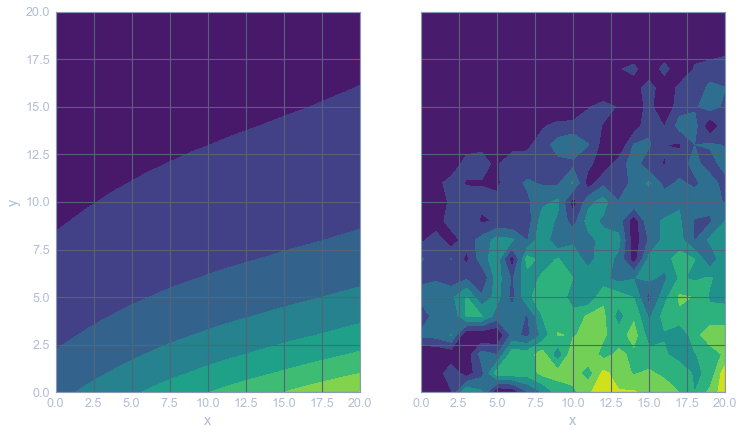

In [99]:
z_pred, z = np.load("predicted_terrain.npy")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7), sharex=True, sharey=True)
ax1.contourf(zz.reshape(21, 21))
ax1.set_title("Predicted")

ax2.contourf(z.reshape(21, 21))
ax2.set_title("Original")
ax1.set_ylabel("y")
ax1.set_xlabel("x")
ax2.set_xlabel("x")
plt.savefig("figures/predicted_terrain.png", dpi=500)